## ATSC 409 Miniproject 2 
 >Angelene Leow, 23162167
 
In an attempt to simulate a real world, herbivores (rabbits) and predators (foxes) are introduced into the Daisyworld model. 
 
**Equations:** 
> white daises: $\dfrac{\partial A_w}{\partial t}$ = $A_w \big( \beta_w(1-A_w + A_b) - \chi - D_w \cdot A_r \big) $<br>
 balck daisies: $  \dfrac{\partial A_b}{\partial t}$ = $A_b\big(\beta_b(1-A_w + A_b) - \chi - D_b \cdot A_r \big)$ <br>
 rabbits: $\dfrac{\partial A_R}{\partial t}$ = $A_r\big(\beta_R(A_w + A_b) - \chi - D_r \cdot A_f\big)$ <br>
foxes: $\dfrac{\partial A_F}{\partial t}$ = $A_f \big(\beta_f \cdot A_r - \chi
 \big)$<br>
 
where for i $\in$ (w, b, r, f):
- $A_i$ = fractions of the total planetary area covered by population $i$ 
- $\beta_i$ = Growth rate <br> 
- $\chi$ = Natural death rate
- $D_i$ = Death rate by predation 
>

In [166]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.testing as npt


class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, 
             self.initvars.blackconc,
             self.initvars.rabbitconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

        self.beta_w_list = [] #initializing empty lists for the growth rates
        self.beta_b_list = []
        self.beta_r_list = []
        
        self.temp_w_list = [] #initializing empty lists for the temperature 
        self.temp_b_list = []
        self.temp_e_list = []
        
    def find_temp(self, yvals):
        """
            Calculate the temperatures over the whiteblack daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)
        
        # set temperature range for growth 
        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
             
        # Liveable temperature range for rabbits = 0˚C - 30˚C
        if (temp_e >= 273.15 and temp_e <= 303.15):
            beta_r = 0.7
        else:
            beta_r = 0.0
            
        # Death rates for daisies (eaten by rabbits)
        Dw = 0.6   # white daisies
        Db = 0.6   # black daisies
        
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi - Dw*y[2])
        f[1] = y[1] * (beta_b * bare - user.chi - Db*y[2])
        f[2] = y[2]*(beta_r * (1- bare) - user.chi_r)        
        
        self.beta_w = beta_w
        self.beta_b = beta_b
        self.beta_r = beta_r

        return f


theSolver = Integ54('miniproject_init.yaml')
timeVals, yVals, errorList = theSolver.timeloop5fixed()
yvals = pd.DataFrame(yVals, columns=['white', 'black','rabbits'])

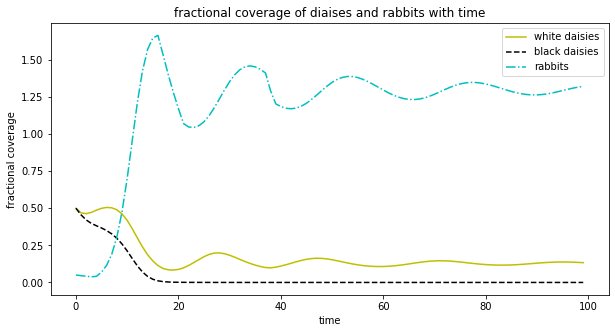

In [167]:
# plot fig
plt.close('all')
thefig, theAx = plt.subplots(1, 1,figsize=(10,5))
white_daisies = theAx.plot(timeVals, yvals['white'], '-y', label='white daisies')
black_daisies = theAx.plot(timeVals, yvals['black'], '--k', label='black daisies')
rab = theAx.plot(timeVals, yvals['rabbits'], '-.c', label = 'rabbits')
theAx.set_title('fractional coverage of diaises and rabbits with time')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

In [187]:
class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc foxesconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc,
             self.initvars.blackconc,
             self.initvars.rabbitconc,
             self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)
        
        # set temperature range for growth 
        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0
        
        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        # Liveable temperature range for rabbits = 0˚C - 30˚C
        if (temp_e >= 273.15 and temp_e <= 303.15):
            beta_r = 0.7
        else:
            beta_r = 0.0
        # Liveable temperature range: -5˚C - 30˚C
        if (temp_e >= 258.15 and temp_e <= 303.15): 
            beta_f = 0.5
        else:
            beta_f = 0.0
            
        # Death rates by predation
        Dw = 0.6   # white daisies
        Db = 0.6   # black daisies
        Dr = 0.4   # rabbits

        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi - Dw*y[2]) # White daisies
        f[1] = y[1] * (beta_b * bare - user.chi - Db*y[2]) # Black daisies
        f[2] = y[2] * (beta_r * (1- bare) - user.chi_r - y[3]*Dr)
        f[3] = y[3] * (beta_f * y[2] - user.chi_f)
        return f


theSolver = Integ54('miniproject_init.yaml')
timeVals, yVals, errorList = theSolver.timeloop5fixed()
yvals2 = pd.DataFrame.from_records(yVals, columns=['white', 'black','rabbits','foxes'])

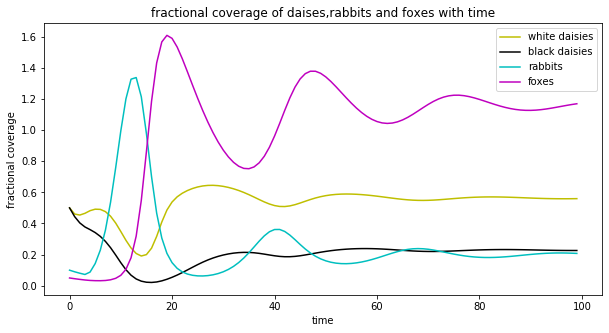

In [188]:
# plot fig
plt.close('all')
thefig, theAx = plt.subplots(1, 1, figsize = (10,5))
white_daisies = theAx.plot(timeVals, yvals2['white'], '-y', label='white daisies')
black_daisies = theAx.plot(timeVals, yvals2['black'], '-k', label='black daisies')
rabbit = theAx.plot(timeVals, yvals2['rabbits'], '-c', label = 'rabbits')
foxes = theAx.plot(timeVals, yvals2['foxes'], '-m', label = 'foxes')
theAx.set_title('fractional coverage of daises,rabbits and foxes with time')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

In [ ]:
#testing unit

yvals_testing = yvals[95:100]

def testme_one():
    theSolver = Integ54('miniproject_init.yaml')
    timeVals, yVals, errorList = theSolver.timeloop5fixed()
    
    
    #  now compare yVals to what you know it should be using
    #  numpy.testing  -- you could test a small range in the middle,
    #  4 or 5 different timepoints, etc.  The idea is just  that it should
    #   fail if timeloop5fixed gets broken down the line sometime
 
    test = np.zeros((5,3))
    test[0] = [0.1442, 0.6593, 0.0221]
    test[1] = [0.3894, 0.2924, 0.6923]
    test[2] = [0.3832, 0.3909, 0.6856]
    test[3] = [0.9186, 0.7472, 0.6780]
    test[4] = [9.3728, 4.6454, 3.6697]

    npt.assert_almost_equal(yvals_testing, test, decimal=4)
    
testme_one()

In [ ]:
yvals_testing = yvals[0:5]

def testme_two():
    theSolver = Integ54('miniproject_init.yaml')
    timeVals, yVals, errorList = theSolver.timeloop5fixed()
    
    
    #  now compare yVals to what you know it should be using
    #  numpy.testing  -- you could test a small range in the middle,
    #  4 or 5 different timepoints, etc.  The idea is just  that it should
    #   fail if timeloop5fixed gets broken down the line sometime
 
    test = np.zeros((5,3))
    test[0] = [0.1442, 0.6593, 0.0221]
    test[1] = [0.3894, 0.2924, 0.6923]
    test[2] = [0.3832, 0.3909, 0.6856]
    test[3] = [0.9186, 0.7472, 0.6780]
    test[4] = [9.3728, 4.6454, 3.6697]
  

    npt.assert_almost_equal(yvals_testing, test, decimal=4)
    
testme_two()

### Write Up
**State all your assumptions, and discuss i) your strategy for finding the steady state ii) whether the various rates are reasonable, given what you know about daisies and mammals (e.g. what do your birth and death rates tell you about the average lifespan of a fox or rabbit on your planet, or the number of rabbits in a litter?)**

> Assumptions: 

- Natural death rate (chi_value) of both daisies are similar (similar environmental conditions)

 
- Similar death rate by predation for daisies. No rabbit biasedness for consumption of  black and white daisies, $D_w = D_b$

- Optimal temperature for rabbits and foxes to live are almost similar (below 30 degrees celcius). 

- Rabbits and foxes have non-zero initial concentration. It makes sense as no organism can exist from zero. 

- Rabbit growth rate ($\beta$) is higher than foxes as rabbits grow in a litter.

> Strategy for finding steady state: 

From lab 5 we have obtained a working steady state model between white and black daisies in the plain Daisyworld version. We then add one predator at a time to see how each addition affects the ecosystem.  

> Reasonability of rates 

Initially, there was a boom in rabbit population due to a pre-existing higher concentration of daisies. This directly resulted in the decrease of daisy population. This leads to a decline in rabbits and foxes, as well as to an increase in temperature.Due to a higher temperature in the atmosphere which favours the growth of white daisies, the black daisies are kept at a lower population. The population of foxes lag behind rabbits but grow at a higher rate due to constant availabiliy of food and lack of predation to decrease its numbers. 

From this experiment we can observe that the larger the number of species, the greater the improving effects on the entire planet (i.e., the temperature regulation was improved). It also showed that the system was robust and stable even when perturbed. Daisyworld simulations where environmental changes were stable gradually became less diverse over time; in contrast gentle perturbations led to bursts of species richness. These findings lent support to the idea that biodiversity is valuabe. 